# Data Filtering with GPT-4 Ratings

## Imports and helper functions

In [2]:
import os
# TODO: Fill in REDIS OM URL in the form of `redis://:password@host:port`
os.environ[
    "REDIS_OM_URL"
] = "redis://:password@server_name:port_num"

import json
import random
from collections import Counter
from sotopia.database.logs import EpisodeLog
from collections import Counter 
import matplotlib.pyplot as plt
import numpy as np
from prompt_reverse_engineering import reverse_episode_log


In [20]:
def get_episodes_by_env_dict(
    tags: list, 
    scenarios: set,
) -> dict[str, list[EpisodeLog]]:
     # Load all episodes from tags
    eps_by_tag = {}
    for tag in tags:
        eps = EpisodeLog.find(EpisodeLog.tag == tag).all()
        if len(eps) > 0:
            eps_by_tag[tag] = eps
    eps_list = sum(eps_by_tag.values(), [])

    # Only select episodes under target scenarios
    eps_by_env = {}
    for ep in eps_list:
        if ep.environment in scenarios:
            if ep.environment in eps_by_env:
                eps_by_env[ep.environment].append(ep)
            else:
                eps_by_env[ep.environment] = [ep]
    
    return eps_by_env

def get_reward_for_agent_model(
    eps_by_env: dict,
    agent_model: str,
    reward_metric: str = 'goal'
) -> dict:
    reward_by_env = {}
    for env, eps in eps_by_env.items():
        score_list = []
        for ep in eps:
            rewards = ep.rewards
            if rewards[0] != 0:
                if ep.models[1] == agent_model:
                    score = rewards[0][1][reward_metric]
                    score_list.append(score)
                if ep.models[2] == agent_model:
                    score = rewards[1][1][reward_metric]
                    score_list.append(score)
            else:
                score = 0
                score_list.append(score)
        reward_by_env[env] = score_list
    
    return reward_by_env


def filter_episodes(
    eps_by_env: dict,
    reward_by_env_gpt: dict,
    agent_model: str,
    filter_threshold: float,
    reward_metric: str = 'goal',
    compare_gpt: bool = True
) -> dict:
    # function to AUTOMATICALLY filter using goal reward scores for each agent position given scenario
    eps_by_env_filtered = {}
    for env, eps in eps_by_env.items():
        eps_by_env_filtered[env] = []
        for ep in eps:
            rewards = ep.rewards
            gpt_avg = np.mean(reward_by_env_gpt[env])
            if rewards[0] != 0:
                if ep.models[1] == agent_model:
                    score, pos = rewards[0][1][reward_metric], 1
                    if compare_gpt:
                        if score > min(filter_threshold, gpt_avg) and rewards[1][1][reward_metric] > min(filter_threshold, max(6, gpt_avg)):
                            eps_by_env_filtered[env].append((ep, pos))
                    else:
                        # if score > filter_threshold and rewards[1][1][reward_metric] > filter_threshold:
                        if score > filter_threshold:
                            eps_by_env_filtered[env].append((ep, pos))
                if ep.models[2] == agent_model:
                    score, pos = rewards[1][1][reward_metric], 2
                    if compare_gpt:
                        if score > min(filter_threshold, gpt_avg) and rewards[0][1][reward_metric] > min(filter_threshold, max(6, gpt_avg)):
                            eps_by_env_filtered[env].append((ep, pos))
                    else:
                        # if score > filter_threshold and rewards[0][1][reward_metric] > filter_threshold:
                        if score > filter_threshold:
                            eps_by_env_filtered[env].append((ep, pos))
    

    return eps_by_env_filtered


def get_train_data_from_eps_list(
    eps_list: list,
    output_file: str
):
    conv_list = []
    for ep in eps_list:
        if ep[1] == 1: # target agent at position 1
            conv = reverse_episode_log(ep[0], include_format=True, later_speak=False)
        else: # target agent at position 2
            conv = reverse_episode_log(ep[0], include_format=True, later_speak=True)
        
        for turn in conv:
            conv_list.append({
                "instruction": "",
                "input": turn['prompt'],
                "output": turn['result']
            })
    
    random.shuffle(conv_list)
    
    with open(output_file, 'w') as f:
        f.write(json.dumps(conv_list, indent=4))

  
def get_sorted_episode_list_for_target_agent(
    tags: list, 
    scenarios: set,
    agent_model: str,
    reward_metric: str = "overall_score"
) -> list:
    
    eps_by_env = get_episodes_by_env_dict(tags, scenarios)
    eps_list = sum(eps_by_env.values(), [])
    
    # Split into two cases where the target agent converses with another agent or itself
    single_agent_eps_list = []
    dual_agent_1_eps_list = []
    dual_agent_2_eps_list = []
    for ep in eps_list:
        if ep.models[1] == agent_model and ep.models[2] == agent_model:
            dual_agent_1_eps_list.append((1, ep))
            dual_agent_2_eps_list.append((2, ep))
        elif ep.models[1] == agent_model or ep.models[2] == agent_model:
            single_agent_eps_list.append((0, ep))

    combined_eps_list = single_agent_eps_list + dual_agent_1_eps_list + dual_agent_2_eps_list

    def reward_sort_fn(x):
        if x[0] == 0:
            return x[1].rewards[0][1][reward_metric] if x[1].models[1] == agent_model else x[1].rewards[1][1][reward_metric]
        elif x[0] == 1:
            return x[1].rewards[0][1][reward_metric]
        else:
            return x[1].rewards[1][1][reward_metric]
        
    sorted_combined_eps_list = sorted(combined_eps_list, key=reward_sort_fn, reverse=True)

    return sorted_combined_eps_list


def select_top_reward_eps(
    sorted_eps_list: list,
    ratio: float = 0.7
) -> list:
    return sorted_eps_list[:round(ratio * len(sorted_eps_list))]


def filter_episodes_on_top_2_selfplay(
    eps_by_env: dict
) -> dict:
    eps_by_env_filtered = {}
    for env, eps in eps_by_env.items():
        # first sort on goal score, second sort on overall score
        eps_by_env_filtered[env] = []
        ep_reward_list_1 = []
        ep_reward_list_2 = []
        for ep in eps:
            if ep.rewards[0] != 0.0:
                    ep_reward_list_1.append((ep.rewards[0][1]["goal"], ep.rewards[0][1]["overall_score"], ep))
            if ep.rewards[1] != 0.0:
                    ep_reward_list_2.append((ep.rewards[1][1]["goal"], ep.rewards[1][1]["overall_score"], ep))
        
        best_1 = sorted(ep_reward_list_1, key=lambda x: (x[0], x[1]), reverse=True)[0]
        best_2 = sorted(ep_reward_list_2, key=lambda x: (x[0], x[1]), reverse=True)[0]
        eps_by_env_filtered[env].append((best_1[2], 1))
        eps_by_env_filtered[env].append((best_2[2], 2))

    return eps_by_env_filtered

## Behavior Cloning Data Filtering (GPT-4 vs. GPT-4)

### Get conversation episodes according to social task scenarios

In [15]:
eps_list = []
# TODO: Fill in the tag. The tag should be the --TAG you used in `../data_generate/scripts/sotopia_conf/generation_utils_conf/generate_xxx.gin`
TAGS = ["sft_round_1_gpt-4_gpt-4_clean"]
with open("../../data_generate/env_files/used_env.json", 'r') as f:
    # TODO: Fill in the experiment name. The name should be the key value of social tasks in `../data_generate/env_files/used_env.json`
    SCENARIOS = json.loads(f.read())["SFT-round-1"]
# TODO: Fill in the target model and gpt model (optional)
TARGET_MODEL = "gpt-4"
GPT_MODEL = "gpt-4"

eps_by_env = get_episodes_by_env_dict(tags=TAGS, scenarios=set(SCENARIOS))
reward_by_env_target = get_reward_for_agent_model(eps_by_env=eps_by_env, agent_model=TARGET_MODEL)
reward_by_env_gpt = get_reward_for_agent_model(eps_by_env=eps_by_env, agent_model=GPT_MODEL)

### Filtering the conversation episodes
We select the top 2 conversations with the highest goal achieving score per social task.

In [16]:
eps_by_env_filtered = filter_episodes_on_top_2_selfplay(eps_by_env)
total_num = 0
for env in eps_by_env_filtered:
    total_num += len(eps_by_env_filtered[env])
    eps_list += eps_by_env_filtered[env]

print(total_num)

200


We plot the goal achieving score distribution among all social tasks.

9.373333333333333 10.0 1.4022888888888891
9.373333333333333 10.0 1.4022888888888891


Text(0.5, 1.0, 'gpt-4')

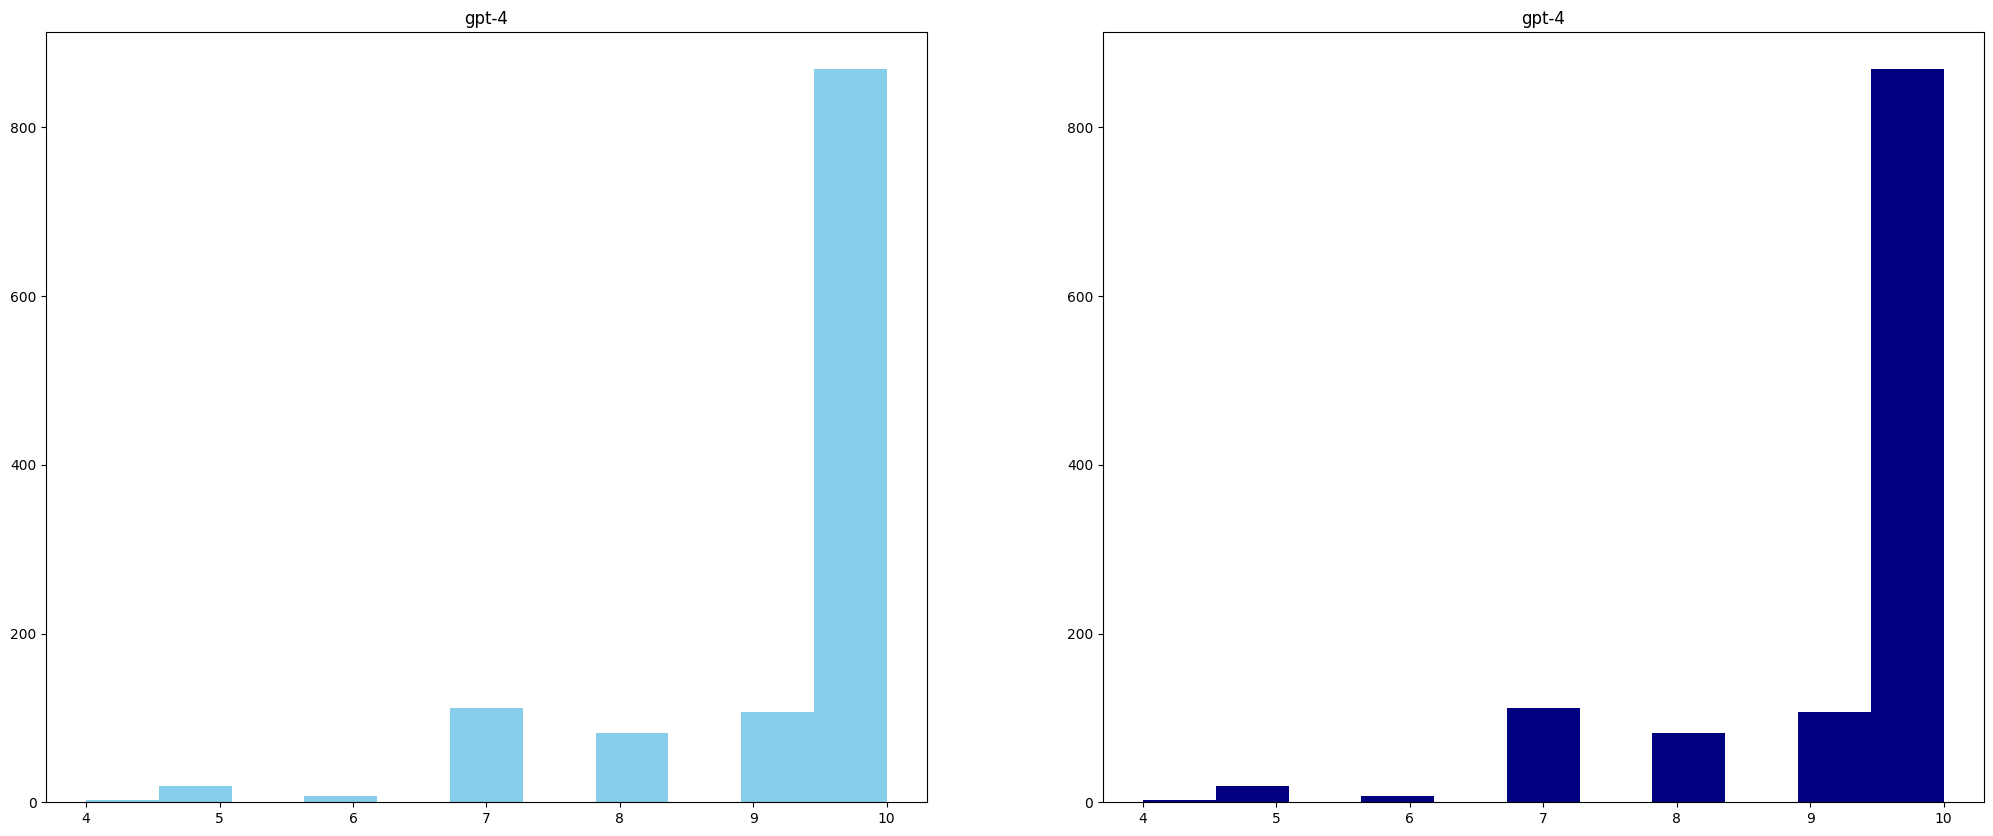

In [17]:
scores_1 = sum(reward_by_env_target.values(), [])
scores_2 = sum(reward_by_env_gpt.values(), [])
print(np.mean(scores_1), np.median(scores_1), np.var(scores_1))
print(np.mean(scores_2), np.median(scores_2), np.var(scores_2))
fig, axs = plt.subplots(1, 2, figsize=(25, 10))
axs[0].hist(scores_1, color='skyblue', bins=11, label='hst')
axs[0].set_title(TARGET_MODEL)
axs[1].hist(scores_2, color='navy', bins=11, label='hst')
axs[1].set_title(GPT_MODEL)

### Generate training data based on filtered conversations

In [16]:
get_train_data_from_eps_list(eps_list=eps_list, output_file="sft_round_1_bc_data_top_2.json")

We might want to filter unsuccessful or skipped responses to reduce overfitting of the model. 

In [17]:
with open("selftrain_sft_round_1_data_top_2.json", 'r') as f:
    line = json.loads(f.read())
    item_list = []
    for item in line:
        if item["output"] == "{\"action_type\": \"none\", \"argument\": \"\"}":
            continue
        item_list.append(item)

with open("selftrain_sft_round_1_data_top_2_filtered.json", 'w') as f:
    f.write(json.dumps(item_list, indent=4))


## Behavior Cloning Data Filtering (Mistral vs. Mistral)

### Get conversation episodes according to social task scenarios

In [28]:
eps_list = []
# TODO: Fill in the tag. The tag should be the --TAG you used in `../data_generate/scripts/sotopia_conf/generation_utils_conf/generate_xxx.gin`
TAGS = ["sft-round-2-selftrain-round-1_checkpoint_improve-0_epoch-20_gpt-3.5-turbo_test"]
with open("../../data_generate/env_files/used_env.json", 'r') as f:
    # TODO: Fill in the experiment name. The name should be the key value of social tasks in `../data_generate/env_files/used_env.json`
    SCENARIOS = json.loads(f.read())["selftrain-round-2"]
# TODO: Fill in the target model and gpt model (optional)
TARGET_MODEL = "custom_model"
GPT_MODEL = "gpt-4"

eps_by_env = get_episodes_by_env_dict(tags=TAGS, scenarios=set(SCENARIOS))
reward_by_env_target = get_reward_for_agent_model(eps_by_env=eps_by_env, agent_model=TARGET_MODEL)
reward_by_env_gpt = get_reward_for_agent_model(eps_by_env=eps_by_env, agent_model=GPT_MODEL)

KeyError: 'selftrain-round-1'

In [27]:
eps_by_env_filtered = filter_episodes_on_top_2_selfplay(eps_by_env)
total_num = 0
for env in eps_by_env_filtered:
    total_num += len(eps_by_env_filtered[env])
    eps_list += eps_by_env_filtered[env]

print(total_num)

0
